# Cocktail Recipe 

### Cocktail Recipe Data

| Column names | name                   | rating | vote_count | instruction                                                                                                                                              |   | Nutrition                                    | Ingredients(1780)                                                                             |
|--------------|------------------------|--------|------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|---|----------------------------------------------|-----------------------------------------------------------------------------------------------|
| Data eg.      | Long Island Tea recipe | 9.2    | 371        | Combine all ingredients (except cola) and pour over ice in a highball glass. Add the splash of cola for color. Decorate with a slice of lemon and serve. |   | 10 nutrition, like sugar,calorie, alcohol... | 1/2 oz vodka;1/2 oz light rum;1/2 oz gin;1/2 oz tequila juice; 1/2 lemons 1 splash Coca-Cola® |

##### Dimension of data frame

| num of rows | num of columns |
|-------------|----------------|
|  8095       | 1794           |


### Explore Ingredients Network 

Build a network of ingredients to explore the relations between ingredients of cocktails. Add an edge between 2 ingredients if they apper in one cocktail; set the weight of edge to be frequency of the 2 ingredients appering in one cocktail.

http://127.0.0.1:8228/index.html

### Invent new cocktail using network


### Try New Cocktail
| Starting Ingredient|  |  |  |  |  |
|----|-----------------|-------------|----------|-----|-------|
|gin | sweet vermouth | orange bitters
|gin | rum | vodka | lemon juice
|gin | grenadine syrup | lime juice
|gin | dry vermouth | Scotch whisky | lemon juice
|gin | sweet and sour mix | 7-Up® soda | triple sec | cranberry juice | peach schnapps|
|gin | lemon juice | brandy|  |   |   |
|gin | grenadine syrup | pineapple juice | Midori® melon liqueur | Malibu® coconut rum|  |


# Code

## Predict rating

In [31]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
from sklearn import base
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV



In [2]:
# read pre-cleaned cocktail data
with open("./data/cocktail_df_cleaned", "rb") as f:
    data_raw = pickle.load(f)

In [3]:
# delete rows without rating
rating_tmp = data_raw.loc[:, 'rating']
data_rating = data_raw.loc[~pd.isnull(rating_tmp),:]
rating = rating_tmp[~pd.isnull(rating_tmp)]
print data_rating.shape, rating.shape

# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(data_rating, rating,
                                                   test_size=0.2,random_state=99)
print X_train.shape, X_test.shape

(8095, 1794) (8095,)
(6476, 1794) (1619, 1794)


In [4]:
# prepare data
class prep_data(base.BaseEstimator, base.RegressorMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        column_names = X.columns.values
        data_X = X.loc[:, column_names[14:]]
        data_X = data_X.fillna(0)
        
        return data_X
    
# my Model 
class rating_est(base.BaseEstimator, base.RegressorMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

In [56]:
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

rating_estimate = Pipeline([
    ('prepare data', prep_data()),
    #('KNN', KNeighborsRegressor())
    #('Ridge', Ridge(alpha = 14))
    ('RF', RandomForestRegressor())
])
rating_estimate

Pipeline(steps=[('prepare data', prep_data()), ('RF', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

## Create new cocktail recipe

### Make network

In [33]:
%matplotlib inline

import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib as mpl
import pygraphviz as pgv

# load data
with open('./data/cocktail_df_cleaned', 'rb') as fp:
    df_raw = pickle.load(fp)
    
# NetWorkX--------------------------
ingredient_names = df_raw.columns.values.tolist()[14:] 
df_ing = df_raw.loc[:, ingredient_names].copy() # ingredient dataframe
G = nx.Graph() # initialize the graph
G.add_nodes_from(ingredient_names) # add nodes
for n in G:
    G.node[n]['name'] = n # add name attr to nodes
# add edges
for r in range(df_ing.shape[0]):
    row = df_ing.loc[r] # current row
    ing_names = row[~row.isnull()].index.tolist() # ingredients in current row
    for c in combinations(range(len(ing_names)),2):
        if G.has_edge(ing_names[c[0]], ing_names[c[1]]):
            G[ing_names[c[0]]][ing_names[c[1]]]['weight'] += 1
        else:
            G.add_edge(ing_names[c[0]], ing_names[c[1]],{'weight':1})
            
# modify network--------------------------------#
### remove edges with small weight
rm_e = list() # edges to be removed
for e in G.edges_iter():
	if G[e[0]][e[1]]['weight'] <= 5:
		rm_e.append(e)
G.remove_edges_from(rm_e) # delete edges
### remove isolate nodes
G.remove_nodes_from(nx.isolates(G))

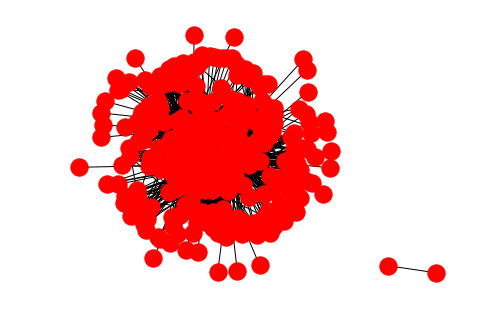

In [36]:
from networkx.drawing.nx_agraph import graphviz_layout
#A = nx.to_agraph(G)
#nx.draw_spring(G)
#nx.draw_graphviz(G)
pos = graphviz_layout(G)
nx.draw(G, pos)

### Invent New Cocktail

In [71]:
# create new cocktail recipe
def create_cocktail(G, start_ing):
    import random
    recipe = []
    # set number of ingredient
    num_ing = random.randrange(3,7,1)
    curr = start_ing
    for i in range(num_ing):
        recipe.append(curr)
        tmp = [(neb, G[curr][neb]['weight']) for neb in
               G.neighbors(curr)]
        tmp_sorted = sorted(tmp, key=lambda x:x[1], reverse=True)[:10]
        next_ing = random.sample([(i,w) for i,w in tmp_sorted if i not in recipe],1)[0][0]
        # jump to next iteration
        curr = next_ing
    return recipe            

In [73]:
for i in range(10):
    cocktail_recipe = create_cocktail(G, 'gin')
    print ' | '.join(cocktail_recipe)

gin | sweet vermouth | orange bitters
gin | rum | vodka | lemon juice
gin | grenadine syrup | lime juice
gin | dry vermouth | Scotch whisky | lemon juice
gin | sweet and sour mix | 7-Up® soda | triple sec | cranberry juice | peach schnapps
gin | lemon juice | brandy
gin | grenadine syrup | pineapple juice | Midori® melon liqueur | Malibu® coconut rum
gin | dry vermouth | vodka
gin | dry vermouth | brandy | sweet vermouth
gin | grenadine syrup | triple sec


In [4]:
# generate interactive graph
!python cocktail_network_static_plot/cocktail_network_static.py


Go to http://127.0.0.1:8228/index.html 

 * Running on http://127.0.0.1:8228/ (Press CTRL+C to quit)
^C
